# Homework 3
Marco Boscato - 2096921

## NUMERICALLY SOLVING A GRAVITATIONAL PROBLEM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline

Article IC

In [2]:
# IC 
mass = 1.5*1e10                                 # kg
G = 6.67*1e-11                                  # m^3 kg^-1 s^-2
pos = np.array([[-10., -0.5], [10., 0.5]])      # m
vel = np.array([[1., 0.], [-1., 0.]])           # m/s
Gm = 1.0                                        # m^3 s^-2

In [3]:
def acceleration(r):
    r1, r2 = r[:2], r[2:]
    r12 = r2 - r1
    r21 = r1 - r2
    a1 = Gm * r12 / np.linalg.norm(r12)**3
    a2 = Gm * r21 / np.linalg.norm(r21)**3
    return np.array([a1, a2]).flatten()

In [4]:
def energy(x, v, m):
    r1, r2 = x[:2], x[2:]
    v1, v2 = v[:2], v[2:]
    r12 = r2 - r1
    return 0.5*m*(np.linalg.norm(v1)**2 + np.linalg.norm(v2)**2) - (G*m**2.)/(np.linalg.norm(r12))

In [5]:
def Euler_method(x, v, t):
    r = x + v*t
    a = acceleration(x)
    v = v + a*t
    return r, v

In [6]:
def Euler_integrator(x, v, max_iter, tol, h):
    t = 0.
    x_list = [x]
    v_list = [v]
    energy_list = [energy(x, v, mass)]
    time_list = [t]

    x_new, v_new = Euler_method(x, v, h)
    x_list.append(x_new)
    v_list.append(v_new)
    energy_list.append(energy(x_new, v_new, mass))
    time_list.append(t + h)

    iter = 0

    while (np.linalg.norm(x_list[-1] - x_list[-2]) > tol and iter<=max_iter):
        x_new, v_new = Euler_method(x_list[-1], v_list[-1], h)
        x_list.append(x_new)
        v_list.append(v_new)
        energy_list.append(energy(x_new, v_new, mass))
        time_list.append(time_list[-1] + h)
        iter += 1
    return np.array(x_list), np.array(v_list), np.array(energy_list), np.array(time_list)

In [7]:
integrated_pos, integrated_vel, system_energy, time = Euler_integrator(pos.flatten(), vel.flatten(), 1000, 1e-6, 1e-1)

# with larger time step
integrated_pos_2, integrated_vel_2, system_energy_2, time_2 = Euler_integrator(pos.flatten(), vel.flatten(), 1000, 1e-6, 5e-1)

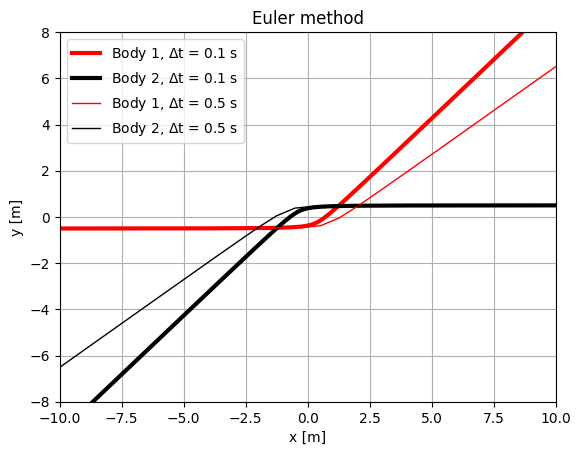

In [8]:
# plot the results
plt.figure()
plt.title('Euler method')
plt.plot(integrated_pos[:,0], integrated_pos[:,1], 'r', label='Body 1, $\Delta$t = 0.1 s', linewidth=3)
plt.plot(integrated_pos[:,2], integrated_pos[:,3], 'black', label='Body 2, $\Delta$t = 0.1 s', linewidth=3)
plt.plot(integrated_pos_2[:,0], integrated_pos_2[:,1], 'r', label='Body 1, $\Delta$t = 0.5 s', linewidth=1)
plt.plot(integrated_pos_2[:,2], integrated_pos_2[:,3], 'black', label='Body 2, $\Delta$t = 0.5 s', linewidth=1)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend()
plt.xlim(-10, 10)
plt.ylim(-8, 8)
plt.grid()

In [9]:
system_energy = system_energy/1e10
system_energy_2 = system_energy_2/1e10

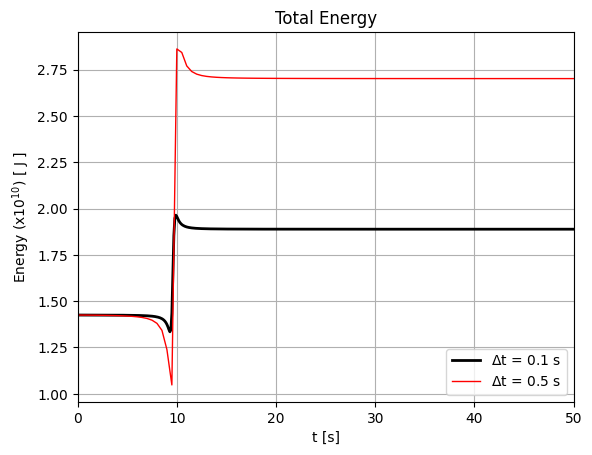

In [10]:
# plot the energy
plt.figure()
plt.title('Total Energy')
plt.plot(time, system_energy, 'black', label='$\Delta$t = 0.1 s', linewidth=2)
plt.plot(time_2, system_energy_2, 'red', label='$\Delta$t = 0.5 s', linewidth=1)
plt.xlabel('t [s]')
plt.ylabel('Energy (x$10^{10}$) [ J ]')
plt.xlim(0, 50)
plt.legend()
plt.grid()

In [13]:
# relative energy error
time_step = np.linspace(0., 1, 50)
energy_error = []

for dt in time_step:
    integrated_pos, integrated_vel, system_energy, time = Euler_integrator(pos.flatten(), vel.flatten(), 1000, 1e-6, dt)
    energy_error.append(np.abs((system_energy[-1] - system_energy[0])/system_energy[0]))

energy_error = np.array(energy_error)

Text(0, 0.5, 'Relative Energy Error')

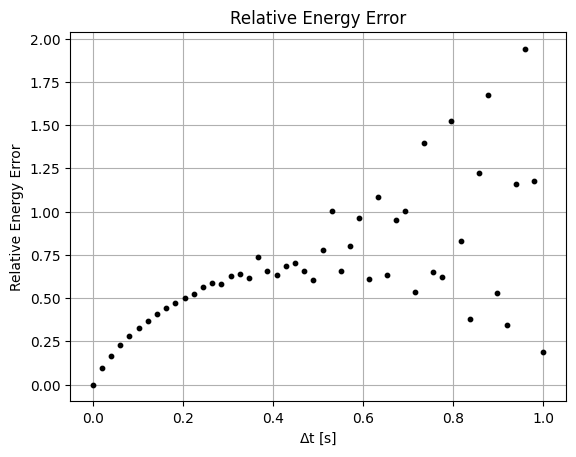

In [18]:
#plot the relative energy error in a scatter plot
plt.figure()
plt.grid()
plt.title('Relative Energy Error')
plt.scatter(time_step, energy_error, color='black', zorder=2, s=10)
plt.xlabel('$\Delta$t [s]')
plt.ylabel('Relative Energy Error')

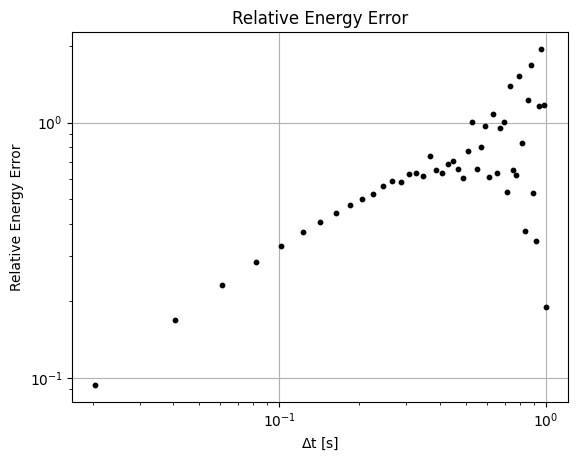

In [19]:
# log-log plot of the relative energy error
plt.figure()
plt.grid()
plt.title('Relative Energy Error')
plt.scatter(time_step, energy_error, color='black', zorder=2, s=10)
plt.xlabel('$\Delta$t [s]')
plt.ylabel('Relative Energy Error')
plt.yscale('log')
plt.xscale('log')
plt.show()

## STABILITY OF PLANETARY SYSTEMS

In [65]:
from Particle import Particles
from scipy.integrate import solve_ivp

# system IC (N-body)

M = 1.0                                     #solar mass 2e30 kg

num_planets = 8
m = M*1e-4*np.ones(num_planets)             #mass of the planets
system_masses = np.concatenate(([0], m))  

orbit_radii = np.linspace(2, 16, num_planets)   # AU

G = 1.0                                     # AU^3 M^-1 s^-2

cut_off_distance = 1e-3                     # AU

t0 = 0.0
tf = 20.0

position = np.zeros([num_planets+1, 2], float)
for i in range(1, num_planets+1):
    position[i] = np.array([orbit_radii[i-1], 0])

velocity = np.zeros([num_planets+1, 2], float)
for i in range(1, num_planets+1):
    velocity[i] = np.array([0,np.sqrt(G*m[i-1]/orbit_radii[i-1])])   # minimum velocity for a circular orbit


system = Particles(position, velocity, mass=system_masses)


In [66]:
def softening_potential(x, m):
    r = np.linalg.norm(x)
    if (r > cut_off_distance):
        return -(G*m**2.)/r
    else:
        return -((2*cut_off_distance**2. - 2*cut_off_distance*r**2. + r**3.)*G*m)/(cut_off_distance**4.)

In [108]:
def acceleration(part):
    n = part.pos.shape[0]
    acc = np.zeros_like(part.pos)
    
    for i in range(n):
        for j in range(n):
            if i != j:
                denom = np.linalg.norm(part.pos[i] - part.pos[j])**3
                temp = - part.mass[j]*(part.pos[i] - part.pos[j])/denom #- softening_potential(part.pos[i] - part.pos[j], part.mass[j])
                acc[i,:] = acc[i,:] + temp
            else:
                pass
    
    return acc

In [100]:
# integrator RK

def Runge_Kutta4_method(part, tstep):
    part.acc = acceleration(part)

    k1_r = tstep * part.vel
    k1_v = tstep * part.acc

    k2_r = tstep * (part.vel + 0.5 * k1_v)
    k2_v = tstep * acceleration(Particles(part.pos + 0.5 * k1_r, part.vel + 0.5 * k1_v, system_masses))

    k3_r = tstep * (part.vel + 0.5 * k2_v)
    k3_v = tstep * acceleration(Particles(part.pos + 0.5 * k2_r, part.vel + 0.5 * k2_v, system_masses))

    k4_r = tstep * (part.vel + 0.5 * k3_v)
    k4_v = tstep * acceleration(Particles(part.pos + 0.5 * k3_r, part.vel + 0.5 * k3_v, system_masses))

    part.pos = part.pos + (k1_r + 2 * k2_r + 2 * k3_r + k4_r) / 6
    part.vel = part.vel + (k1_v + 2 * k2_v + 2 * k3_v + k4_v) / 6

    return part


In [109]:
# Integration
n_steps = 1000
h = (tf - t0)/n_steps
time = np.linspace(t0, tf, n_steps)

orbit_path = []
orbit_vel = []

for i in range(n_steps):
    update_system = Runge_Kutta4_method(system, h)
    orbit_path.append(update_system.pos)
    orbit_vel.append(update_system.vel)

In [110]:
orbit_path = np.array(orbit_path)
orbit_vel = np.array(orbit_vel)

print(orbit_path.shape)

(1000, 9, 2)


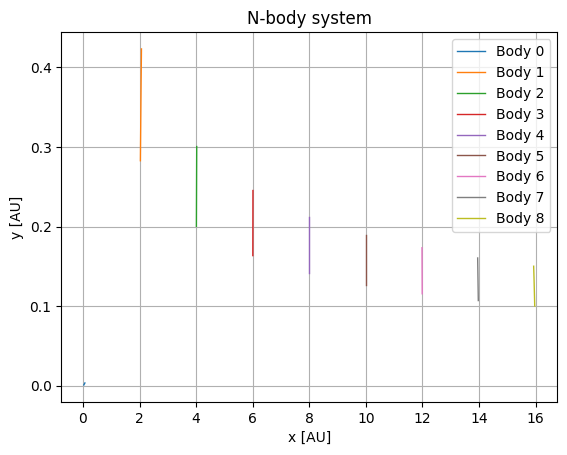

In [111]:
# plot the results
plt.figure()
plt.title('N-body system')
for i in range(num_planets+1):
    plt.plot(orbit_path[:,i,0], orbit_path[:,i,1], label='Body %d'%(i), linewidth=1)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend()
plt.grid()